# Transilien - Challenge Data

## 1. EDA


In [ ]:
import pandas as pd
import os
if not os.path.exists("results/"):
    os.makedirs("results")
SOURCES_DIR = "sources/"

# TRAINING SET
X = pd.read_csv(SOURCES_DIR + "x_train_final.csv")

Y = pd.read_csv(SOURCES_DIR + "y_train_final.csv")
# EVAL SET 
#X_Eval = pd.read_csv(SOURCES_DIR + "x_test_final.csv")

Describe complete dataset:

In [3]:
pd.concat([X,Y], axis=1).columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'train', 'gare', 'date', 'arret', 'p2q0',
       'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4', 'Unnamed: 0', 'p0q0'],
      dtype='object')

On peut voir qu'il y a trois colonnes inutile ```'Unnamed: 0.1', 'Unnamed: 0','Unnamed: 0'``` que l'on peut supprimer et on peut renommer notre cible.

In [4]:
X.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], inplace=True)
Y.drop(columns=["Unnamed: 0"], inplace=True)
Y.rename(columns={"p0q0": "Target"}, inplace=True)


In [5]:
pd.concat([X,Y], axis=1).describe(include='all')

,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,Target
count,667264,667264,667264,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000
unique,37544,84,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,PBYUMJ,JLR,2023-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,50,31643,8417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,18.277499,-0.170696,-0.167304,-0.176308,-0.163223,-0.173579,-0.174436,-0.159950
std,NaN,NaN,NaN,7.030424,1.976521,1.960416,1.926275,1.988527,2.643148,4.732999,1.987872
min,NaN,NaN,NaN,7.000000,-160.000000,-160.000000,-160.000000,-160.000000,-1441.000000,-1441.000000,-160.000000
25%,NaN,NaN,NaN,12.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,NaN,NaN,NaN,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Nous noterons TA le temps d'attente

Nous noterons k le train dont nous souhaitons savoir le TA

Nous noterons s la gare a laquelle le TA de k est estimé



- train:  ID du train
- gare:   ID de gare
- date:   date
- arret:  num arret [8-12]
- p2q0:   Le TA de k a -2 gare
- p3q0:   Le TA de k a -3 gare
- p4q0:   Le TA de k a -4 gare
- p0q2:   Le TA du train -2 a s
- p0q3:   Le TA du train -3 a s
- p0q4:   Le TA du train -4 a s


In [6]:
X.dtypes

train     object
gare      object
date      object
arret      int64
p2q0     float64
p3q0     float64
p4q0     float64
p0q2     float64
p0q3     float64
p0q4     float64
dtype: object

Nos features peuvent se separer en plusieurs catégories, les variables catégorielles comme ```train``` et ```gare```, une variable temporelle ```date``` et des variables numériques `arret`, `p2q0`, `p3q0`, `p4q0`, `p0q2`, `p0q3` et `p0q4`

> Etude des variables numériques

`Arret` est la variable qui répresente la position du train dans son trajet, cette valeur n'est pas une mesure, elle ne permet pas d'en tirer de l'information, deux trains peuvent être à leur arrêt n°3 sans être dans la même gare ou même la même ligne.
L'utilisation de cette variable pour entrainer notre modèle est donc inutile.  

Les variables de type pXqY représente la différence entre le temps réél et le temps prévu de différents trains à différentes gares, ce sont des variables numériques qui peuvent être utilisé pour notre modèle.
Pour les utiliser il faut d'abord les nettoyer (valeurs abérentes) et les standardiser 

<Axes: >

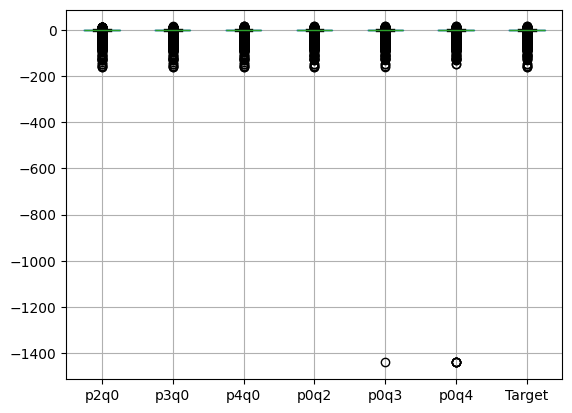

In [7]:
import matplotlib.pyplot as plt
# études des valeurs abérrentes
numCols = ["p2q0", "p3q0","p4q0", "p0q2", "p0q3", "p0q4"]
num_df = X[numCols]
df = pd.concat([num_df,Y], axis=1)
df.boxplot()

On peut voir que deux de nos features comportent des valeurs très inferieurs aux autres, même si ces valeurs peuvent être valide logiquement elles ne représentent pas un phénomène assez récurent pour les inclure dans notre dataset d'entrainement.
On peut mettre une valeur minimum pour ces variables, ici on peut choisir -200 

In [8]:
df = df[(df > -200).all(axis=1)]
df.boxplot()

<Axes: >

In [9]:
# étude du tailness (queue de distribution)
df.kurtosis()

p2q0       970.072810
p3q0       992.575043
p4q0      1029.175404
p0q2       921.910824
p0q3       850.161169
p0q4       744.363971
Target     869.678216
dtype: float64

La distribution de chacune des features est semblable à la distribution de notre target, on peut donc dire que le traitement des features est donc acceptable. 

In [10]:
X = X[(X[numCols] > -200).all(axis=1)]


> Etudes de la variable temporelle

Comparaison entre les dates du set d'entrainement et du set de test

In [11]:
x_eval = pd.read_csv(SOURCES_DIR + "x_test_final.csv").drop(columns=['Unnamed: 0'])
#print(f'Minimum date X:{X['date'].min()}, Maximum date X:{X["date"].max()}')
#print(f'Minimum date X eval:{x_eval['date'].min()}, Maximum date X eval:{x_eval["date"].max()}')

On peut voir que les données du dataset d'entrainement (X) commencent en Avril 2023 et finissent en Novembre 2023 alors que les données de test commencent en Novembre 2023 et finissent en décembre 2023.
Nous ne pouvons donc pas utiliser cette feature pour en détérminer d'autres comme la saisonalité, la température ou la météo car ces paramètres ne sont pas comparables entre nos données d'entrainement et de test (la météo par exemple n'est vraiment pas la même en décembre que en juin).
Nous pourrons peut-être utilisé la date comme repère au sein d'une semaine lors du feature engineering

A noter que comme l'ordre des données est important il faudra le prendre en compte lors de la séparation de notre dataset en X_train X_test

> Etude des variables catégorielles

Les variables catégorielles ne peuvent pas vraiment être utilisés pour entrainer notre modèle.

Nous verrons lors du feature engineering si nous pouvons en tirer des informations.

## 2. Premier entrainement

Pour tester nos données et se faire une première idée nous pouvons tester nos données sur un Random Forest

In [12]:
print(X.columns)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
X['Target'] = Y["Target"]
X = X.sort_values(by='date')
split_index = int(0.8 * len(X))
target = X['Target']
features = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = target[:split_index], target[split_index:]
#clf = RandomForestRegressor(n_estimators = 100, random_state = None,criterion='squared_error',oob_score=True,n_jobs=-1,max_depth=18,min_samples_leaf=5)
clf = RandomForestClassifier(max_depth=18,n_estimators=20,  random_state=None, n_jobs=-1)
clf.fit(X_train[features], Y_train)
pred = clf.predict(X_test[features])
from sklearn.metrics import mean_absolute_error as mae
print(f'MAE Validation: {mae(Y_test, pred)}')


Index(['train', 'gare', 'date', 'arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2',
       'p0q3', 'p0q4'],
      dtype='object')
MAE Validation: 0.7800707370440308


## 3. Feature Engineering

Pour améliorer notre score nous pouvons créer de nouvelles informations depuis nos features.

> Ranking des gares

Nous pouvons identifier chaque gare par son ID et la placer dans le trajet d'un train grâce au numéro d'arret. Cela nous permet de savoir quelle est la gare suivante ou précédente et donc de représenter nos gares par un graph et d'en tirer plus d'information.

In [13]:
X.columns

Index(['train', 'gare', 'date', 'arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2',
       'p0q3', 'p0q4', 'Target'],
      dtype='object')

In [14]:
import copy
import networkx as nx
sub_graphs = {}
X['date'] = pd.to_datetime(X['date'])
 
for day,group_day in X.groupby('date') :
    sub_G = nx.DiGraph()
    for _,group_train in group_day.groupby('train'):
        
        group_train = group_train.sort_values('arret')
        gare = group_train.gare.values
        stops = group_train.arret.values
        delays = group_train.p0q2.values
        edges = [(gare[i],gare[i+1]) for i in range(len(gare) -1) if stops[i+1] == stops[i] + 1]
        sub_G.add_edges_from(edges)
 
        for i in range(len(edges)):
            try :
                delay = sub_G.edges[edges[i]]['delay']
                count = sub_G.edges[edges[i]]['count']
                nx.set_edge_attributes(sub_G,{edges[i]: {'delay' : delay + delays[i+1],'count' : count + 1}})
            except:
                nx.set_edge_attributes(sub_G,{edges[i]: {'delay' : delays[i+1],'count' : 1}})
    sub_graphs[str(day.date())] = copy.deepcopy(sub_G)
 
G = nx.DiGraph()
for g in sub_graphs.values():
    G = nx.compose(G,g)
 
edge_data = {}
for e in G.edges:
    edge_data[e] = {'delay':0,'count':0}
    for g in sub_graphs.values():
        if e in g.edges :
            edge_data[e]['delay'] = edge_data[e]['delay'] + g.edges[e]['delay']
            edge_data[e]['count'] = edge_data[e]['count'] + g.edges[e]['count']
 
nx.set_edge_attributes(G,edge_data)
del edge_data

In [15]:
len(G.nodes())

84

### Eigen Centrality

La centralité représente la place de notre gare dans notre graph, cette

In [16]:
centrality_df = pd.DataFrame.from_dict(nx.eigenvector_centrality(G, weight="count", max_iter=1000), orient='index', columns=['centrality']).reset_index(names='gare')

### Neighbor_delay_mean

In [17]:
# Create an empty dictionary to store the mean delay for each node
node_mean_delay = {}

# Iterate over each node in the graph
for node in G.nodes:
    total_delay = 0
    total_count = 0
    
    # Iterate over all neighbors of the node (both incoming and outgoing edges)
    for neighbor in G.neighbors(node):
        # Get the edge between the node and its neighbor
        edge_data = G.get_edge_data(node, neighbor)
        
        # Calculate the weighted delay for this edge (delay * count)
        delay = edge_data["delay"]  # delay attribute
        count = edge_data["count"]  # count attribute
        
        # Sum the delays and counts to compute the weighted mean
        total_delay += delay * count
        total_count += count
    
    # If there are neighbors, calculate the weighted mean delay for the node
    if total_count > 0:
        node_mean_delay[node] = total_delay / total_count
    else:
        node_mean_delay[node] = 0  # If no neighbors, set delay to 0

# Output the weighted mean delays for each node
neighbor_delay_df = pd.DataFrame.from_dict(node_mean_delay, orient='index', columns=['neighbor_delay']).reset_index(names='gare')
neighbor_delay_df.shape

(84, 2)

### node2vec

In [18]:
from node2vec import Node2Vec
from gensim.models import Word2Vec
import numpy as np

dim = 32
node2vec = Node2Vec(G, dimensions=dim, walk_length=20, num_walks=400, workers=1, seed=42)
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Train Word2Vec model
nodes = list(G.nodes())  # Get node list
embeddings = np.array([model.wv[node] for node in nodes])  # Retrieve embeddings
n2v_df = pd.DataFrame(embeddings, index=nodes)
n2v_df.index.name = "gare"
n2v_df.columns = [f"n2v_dim_{i}" for i in range(embeddings.shape[1])]
n2v_df.head()


Computing transition probabilities:   0%|          | 0/84 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 400/400 [00:00<00:00, 537.48it/s]


,n2v_dim_0,n2v_dim_1,n2v_dim_2,n2v_dim_3,n2v_dim_4,n2v_dim_5,n2v_dim_6,n2v_dim_7,n2v_dim_8,n2v_dim_9,...,n2v_dim_22,n2v_dim_23,n2v_dim_24,n2v_dim_25,n2v_dim_26,n2v_dim_27,n2v_dim_28,n2v_dim_29,n2v_dim_30,n2v_dim_31
gare,,,,,,,,,,,,,,,,,,,,,
OJA,0.507148,-0.471593,0.779702,-0.115934,-0.033448,-0.573742,-0.186358,0.103128,-0.284265,-0.005853,...,0.683856,0.554231,-0.102006,0.403273,-0.378941,-0.042145,0.322520,-0.175137,-0.336602,-0.343602
ELZ,0.284330,-0.326405,0.774444,0.060569,-0.059217,-0.301916,0.392247,0.034888,-0.205089,-0.046661,...,0.387644,0.206279,0.156247,0.541461,-0.198723,-0.321726,0.404683,-0.430902,-0.180803,-0.261840
ZHN,0.228065,-0.316640,0.610269,-0.138866,0.134424,-0.082857,-0.248816,0.275596,-0.112945,-0.100075,...,0.548580,0.119403,-0.098387,0.342281,-0.316335,-0.291533,0.220180,-0.585731,-0.086033,0.313226
KYF,0.325646,-0.284495,0.568499,0.154657,0.270077,0.130563,-0.046279,0.191856,-0.005002,0.055153,...,0.323495,0.103825,-0.146756,0.353262,-0.244275,-0.288779,0.236510,-0.317321,-0.111585,0.133927
JLR,0.147026,0.068405,0.585476,-0.190671,0.285111,-0.099070,-0.010051,0.271686,0.038007,-0.002762,...,0.246062,0.115026,-0.026862,0.512985,-0.157481,-0.251940,0.245358,-0.450107,0.019373,0.110520


In [19]:
n2v_df.head()

,n2v_dim_0,n2v_dim_1,n2v_dim_2,n2v_dim_3,n2v_dim_4,n2v_dim_5,n2v_dim_6,n2v_dim_7,n2v_dim_8,n2v_dim_9,...,n2v_dim_22,n2v_dim_23,n2v_dim_24,n2v_dim_25,n2v_dim_26,n2v_dim_27,n2v_dim_28,n2v_dim_29,n2v_dim_30,n2v_dim_31
gare,,,,,,,,,,,,,,,,,,,,,
OJA,0.507148,-0.471593,0.779702,-0.115934,-0.033448,-0.573742,-0.186358,0.103128,-0.284265,-0.005853,...,0.683856,0.554231,-0.102006,0.403273,-0.378941,-0.042145,0.322520,-0.175137,-0.336602,-0.343602
ELZ,0.284330,-0.326405,0.774444,0.060569,-0.059217,-0.301916,0.392247,0.034888,-0.205089,-0.046661,...,0.387644,0.206279,0.156247,0.541461,-0.198723,-0.321726,0.404683,-0.430902,-0.180803,-0.261840
ZHN,0.228065,-0.316640,0.610269,-0.138866,0.134424,-0.082857,-0.248816,0.275596,-0.112945,-0.100075,...,0.548580,0.119403,-0.098387,0.342281,-0.316335,-0.291533,0.220180,-0.585731,-0.086033,0.313226
KYF,0.325646,-0.284495,0.568499,0.154657,0.270077,0.130563,-0.046279,0.191856,-0.005002,0.055153,...,0.323495,0.103825,-0.146756,0.353262,-0.244275,-0.288779,0.236510,-0.317321,-0.111585,0.133927
JLR,0.147026,0.068405,0.585476,-0.190671,0.285111,-0.099070,-0.010051,0.271686,0.038007,-0.002762,...,0.246062,0.115026,-0.026862,0.512985,-0.157481,-0.251940,0.245358,-0.450107,0.019373,0.110520


### pagerank

In [20]:
pr_df = pd.DataFrame(list(nx.pagerank(G).items()), columns=["gare", "PageRank"])

In [21]:
# Add new features to dataframe
X = pd.merge(X, centrality_df, on="gare")
X = pd.merge(X, neighbor_delay_df, on='gare')
X = pd.merge(X, pr_df, on="gare")
X.columns
X_save = X

In [22]:
X = X_save


In [23]:
X = pd.merge(X, n2v_df, on="gare")

In [24]:
X.columns

Index(['train', 'gare', 'date', 'arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2',
       'p0q3', 'p0q4', 'Target', 'centrality', 'neighbor_delay', 'PageRank',
       'n2v_dim_0', 'n2v_dim_1', 'n2v_dim_2', 'n2v_dim_3', 'n2v_dim_4',
       'n2v_dim_5', 'n2v_dim_6', 'n2v_dim_7', 'n2v_dim_8', 'n2v_dim_9',
       'n2v_dim_10', 'n2v_dim_11', 'n2v_dim_12', 'n2v_dim_13', 'n2v_dim_14',
       'n2v_dim_15', 'n2v_dim_16', 'n2v_dim_17', 'n2v_dim_18', 'n2v_dim_19',
       'n2v_dim_20', 'n2v_dim_21', 'n2v_dim_22', 'n2v_dim_23', 'n2v_dim_24',
       'n2v_dim_25', 'n2v_dim_26', 'n2v_dim_27', 'n2v_dim_28', 'n2v_dim_29',
       'n2v_dim_30', 'n2v_dim_31'],
      dtype='object')

In [25]:
X.to_csv('sources/x_train_post_engineering.csv')

Nouvelles Features:
- Centrality: Représente la centralité d'une gare au sein du réseau
- neighbor_delay:  

## 3.A Neural Network Embedding

In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import mlflow
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_absolute_error as mae

# Vars
dim = 32

# MODEL
class mainModel(tf.keras.Model):
    def __init__(self):
        super(mainModel,self).__init__()
        self.dense1 = tf.keras.layers.Dense(256,activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(128,activation = 'relu')
        self.dense3 = tf.keras.layers.Dense(64,activation = 'relu')
        self.dense4 = tf.keras.layers.Dense(32,activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(1,activation = 'linear')
    
    def get_dense(self,X):
        X = self.dense1(X)
        X = self.dense2(X)
        X = self.dense3(X)
        X = self.dense4(X)
        return X
 
    def call(self,X):
        X = self.get_dense(X)
        X = self.output_layer(X)
        return X
    
# CALLBACKS
class MAECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        mae_score = mae(self.y_val, y_pred)
        mlflow.log_metric("MAE", mae_score, step=epoch)
 
# DATA
X = pd.read_csv("sources/x_train_post_engineering.csv")
Y = pd.read_csv(SOURCES_DIR + "y_train_final.csv")
X = X.sort_values(by='date')
split_index = int(0.8 * len(X))
target = X['Target']
features = ['arret','p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4', 'centrality', 'neighbor_delay', 'PageRank']
for x in range(dim):
    features.append(f"n2v_dim_{x}")
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = target[:split_index], target[split_index:]
X_train.loc[:, features] = (X_train[features] - X_train[features].mean()) / X_train[features].std()
X_test.loc[:, features] = (X_test[features] - X_test[features].mean()) / X_test[features].std()


2025-03-27 11:01:41.267921: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 11:01:41.379445: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 11:01:41.417851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743069701.499147   10831 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743069701.515893   10831 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743069701.645334   10831 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
# TRAINING
from sklearn.metrics import mean_absolute_error as mae
use_mlflow = False
num_epochs = 10
batch_size = 1000
model = mainModel()
if use_mlflow:
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    mlflow.set_experiment("Embedding Neural Network")
    with mlflow.start_run():
        mlflow.log_param("Number of layer", len(model.layers))
        model.compile(optimizer='adamax',
                    loss= 'mae',
                    metrics=[])
        model.fit(X_train[features].values, Y_train.values, 
                validation_data=(X_test[features], Y_test),
                epochs=num_epochs,
                batch_size=batch_size,
                callbacks=[MAECallback(X_test[features], Y_test)])
        embedded_layer = model.get_dense(X_train[features].values)
else:
    model.compile(optimizer='adamax',
                    loss= 'mae',
                    metrics=[])
    model.fit(X_train[features].values, Y_train.values, 
                validation_data=(X_test[features], Y_test),
                epochs=num_epochs,
                batch_size=batch_size)
    embedded_layer = model.get_dense(X_train[features].values)  


## 3.B KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error as mae

neigh = KNeighborsClassifier(n_neighbors=128, weights='distance')
neigh.fit(embedded_layer, Y_train)
pred = neigh.predict(model.get_dense(X_test[features]))

mae(Y_test, pred)
#0.6349923568024458


In [ ]:
x_eval = pd.read_csv(SOURCES_DIR + "x_test_final.csv")

In [ ]:

x_eval = pd.merge(x_eval, centrality_df, on="gare")
x_eval = pd.merge(x_eval, neighbor_delay_df, on='gare')
x_eval = pd.merge(x_eval, pr_df, on="gare")
x_eval = pd.merge(x_eval, n2v_df, on="gare")
x_eval = (x_eval[features] - x_eval[features].mean())/x_eval[features].std() 

In [ ]:
eval_prediction = neigh.predict(model.get_dense(x_eval[features]))
prediction = pd.DataFrame(eval_prediction, columns=['p0q0']).to_csv('results/predictionKNN.csv')

## 3.C RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_post_FE = RandomForestClassifier(max_depth=18,n_estimators=120, random_state=42, n_jobs=-1, min_samples_split=10, max_features=int(0.3*len(features)))
clf_post_FE.fit(embedded_layer, Y_train)
pred = clf_post_FE.predict(model.get_dense(X_test[features].values))
print(f'MAE Validation: {mae(Y_test, pred)}')

## 4. Random Forest Classifier post engineering

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
X = X.sort_values(by='date')
split_index = int(0.8 * len(X))
target = X['Target']
features = ['arret','p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4', 'centrality', 'neighbor_delay', 'PageRank']
for x in range(dim):
    features.append(f"n2v_dim_{x}")
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = target[:split_index], target[split_index:]
#clf_post_FE = RandomForestRegressor(n_estimators = 100, random_state = None,criterion='squared_error',oob_score=True,n_jobs=-1,max_depth=18,min_samples_leaf=5)
clf_post_FE = RandomForestClassifier(max_depth=18,n_estimators=120, random_state=42, n_jobs=-1, min_samples_split=10, max_features=int(0.3*len(features)))
clf_post_FE.fit(X_train[features], Y_train)
pred = clf_post_FE.predict(X_test[features])
from sklearn.metrics import mean_absolute_error as mae
print(f'MAE Validation: {mae(Y_test, pred)}')


## 5. Evaluation

In [ ]:
x_eval = pd.read_csv(SOURCES_DIR + "x_test_final.csv").drop(columns=['Unnamed: 0'])

In [ ]:
x_eval = pd.merge(x_eval, centrality_df, on="gare")
x_eval = pd.merge(x_eval, neighbor_delay_df, on='gare')
x_eval = pd.merge(x_eval, pr_df, on="gare")
x_eval = pd.merge(x_eval, n2v_df, on="gare")

In [ ]:
eval_prediction = clf_post_FE.predict(x_eval[features])
prediction = pd.DataFrame(eval_prediction, columns=['p0q0']).to_csv('results/predictionRFC.csv')

### Meilleur score sur [challenge-data](https://challengedata.ens.fr/): 
> GraphicCardEater : 0.6658

In [ ]:
raise SystemExit("End of notebook!")

## 5. Recherche d'un autre modele

In [ ]:
X = pd.read_csv("sources/x_train_post_engineering.csv")
X.head()

In [ ]:
X = X.sort_values(by='date')
split_index = int(0.8 * len(X))
target = X['Target']
features = ['arret','p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4', 'centrality', 'neighbor_delay', 'PageRank']
for x in range(dim):
    features.append(f"n2v_dim_{x}")
#features = ['arret','p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = target[:split_index], target[split_index:]

### XGBOOST

In [ ]:
import xgboost as xgb

xgb_r = xgb.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 120, seed = 42) 

xgb_r.fit(X_train[features], Y_train) 
# Predict the model 
xgb_pred = xgb_r.predict(X_test[features])
from sklearn.metrics import mean_absolute_error as mae
print(f'MAE Validation: {mae(Y_test, xgb_pred)}')

### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train[features], Y_train)
gbr_pred = model.predict(X_test[features])
print(f'MAE Validation: {mae(Y_test, gbr_pred)}')


### Kmeans

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(X_train[features])
kmeans.predict(X_test[features])
kmeans.cluster_centers_